In [1]:
# Remove warnings
import warnings

warnings.filterwarnings('ignore')

# Data manipulation 
import pandas as pd
# Dates handling
from datetime import datetime, timedelta
import pytz
from dateutil.relativedelta import relativedelta
# Chart modules
import matplotlib.pyplot as plt
import seaborn as sns


# Linear algrebra
import numpy as np


# Technical indicators
from scipy.signal import savgol_filter, convolve, lfilter


from modules.Utils.utils import loadFromDB, computeFutureLinearRegression, strategyTester
from modules.Utils.indicators import computeLaggingLinearRegression, computeTrixIndicator, addIndicators, computeRSI_VWAP, computeMASlope

In [2]:
SYMBOL= 'AVAX'
df = loadFromDB(f'../backtest_tools/database/database/Binance/1h/{SYMBOL}-USDT.csv')
df = df[-10000:]
df.head()

Total records : 16186 rows


,Open,High,Low,Close,Volume,Timestamp
Date,,,,,,
2021-06-07 15:00:00,17.515,17.550,17.300,17.323,50244.828,1623070800
2021-06-07 16:00:00,17.337,17.337,17.100,17.188,90269.788,1623074400
2021-06-07 17:00:00,17.181,17.321,17.100,17.266,65292.310,1623078000
2021-06-07 18:00:00,17.259,17.355,17.011,17.043,65621.166,1623081600
2021-06-07 19:00:00,17.035,17.087,16.729,16.898,127761.843,1623085200


In [3]:
from statsmodels.tsa.filters.hp_filter import hpfilter

def filterData(data, method='savgol')->np.array:
    """function the filter a signal with a specific method.

    Args:
        data (np.array): The input signal to denoise.
        method (str): The filtering/denoising method. Default to 'savgol'.

    Returns:
        np.array: The filtered signal.
    """
    if method=='savgol':
        return savgol_filter(data, 30, 2, mode='nearest')
    elif method=='hpf':
        cycle, trend = hpfilter(data,120)
        return trend 

In [4]:
df = addIndicators(df)
df['EMA20_denoised'] = filterData(df.EMA20.values,'hpf')#savgol_filter(df.EMA20.values, 30, 2, mode='nearest')
df['EMA20_diff'] = df.EMA20_denoised.diff(1)
df.dropna(inplace=True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


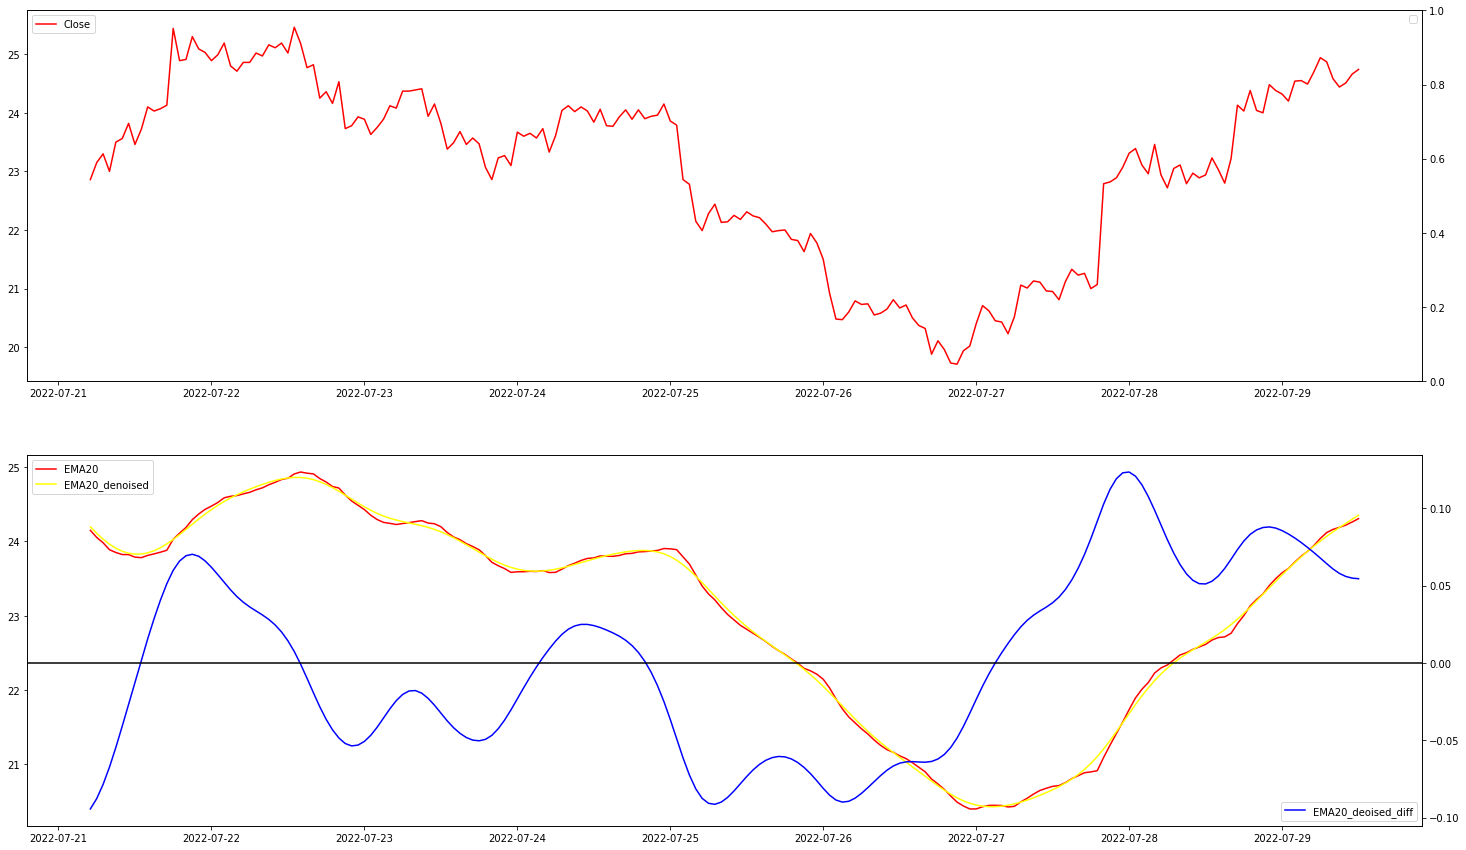

In [5]:
fig, ax_left = plt.subplots(2, figsize=(25,15))
ax_right =[]

ind=200

ax_right.append(ax_left[0].twinx())
ax_right.append(ax_left[1].twinx())

ax_left[0].plot(df.Close[-ind:], color='red',label='Close')
ax_left[0].legend(loc="upper left")
ax_right[0].legend(loc="upper right")

ax_left[1].plot(df.EMA20[-ind:], color='red',label='EMA20')
ax_left[1].plot(df.EMA20_denoised[-ind:], color='yellow',label='EMA20_denoised')
ax_right[1].plot(df.EMA20_diff[-ind:], color='blue',label='EMA20_deoised_diff')
ax_right[1].axhline(y=0, color='black')
ax_left[1].legend(loc="upper left")
ax_right[1].legend(loc="lower right")
#sns.histplot(data=df['B_MLR_coefs'], ax = ax_leRSIft[1])

Period : [2022-01-02 04:00:00] -> [2022-07-29 12:00:00]
Starting balance : 1000 $

----- General Informations -----
Final balance : 50337.33 $
Performance vs US Dollar : 4933.73 %
Buy and Hold Performence : -78.91 %
Performance vs Buy and Hold : -6352.45 %
Best trade : +23.67 %, the 2022-07-20 16:00:00
Worst trade : -1.83 %, the 2022-01-27 18:00:00
Worst drawBack : -2.0 %
Total fees :  1245.49 $

----- Trades Informations -----
Total trades on period : 80
Number of positive trades : 69
Number of negative trades :  11
Trades win rate ratio : 86.25 %
Average trades performance : 5.25 %
Average positive trades : 6.22 %
Average negative trades : -0.81 %

----- Plot -----


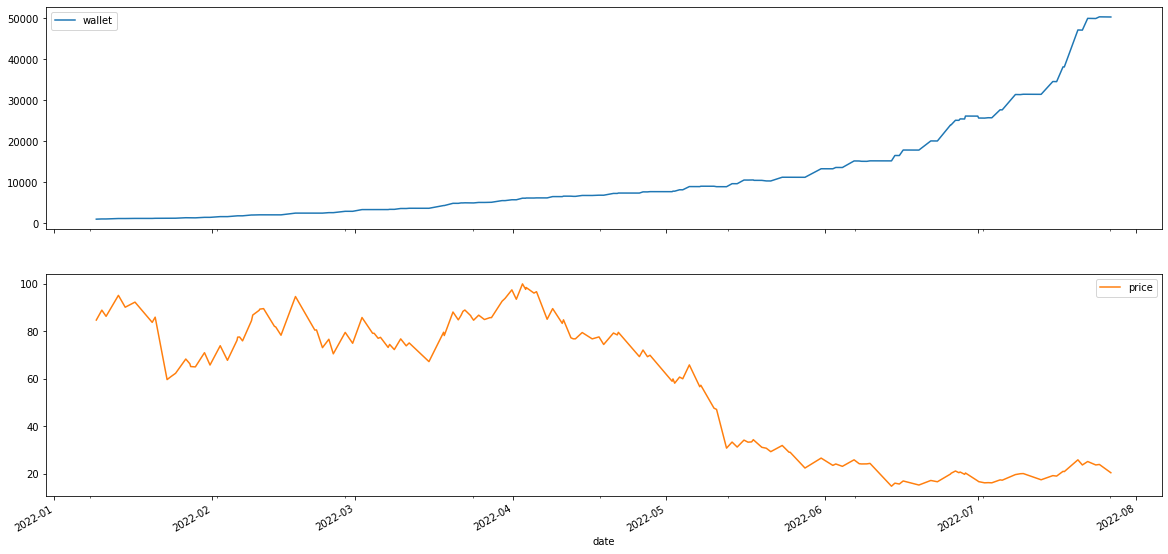

In [12]:
def buyCondition(row:pd.Series, previous_row:pd.Series=None)->bool:
    return True if previous_row.EMA20_diff<0 and row.EMA20_diff>0 else False

def sellCondition(row:pd.Series, previous_row:pd.Series=None)->bool:
    return True if previous_row.EMA20_diff>0 and row.EMA20_diff<0 else False

strategyTester(df.iloc[-5000:],buyCondition,sellCondition,equity=1000)